# Set the background stratification, mean zonal velocity, and layer depths for Ian and Scott's QG code

In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# In this cell set the number of layers and the choice of stretched vertical coordinate using alpha
nz = 4
alpha = 2
Htot = 4800

In [3]:
# In this cell define N^2(z)/f^2.
# Note the convention that z=0 is at the bottom and z=H is at the top; compare this to the alternative convention
# (not adopted here) that z=0 at the top and z=-H at the bottom.
def N2(t):
    #return 1 + 0*t
    return ( 1 + 9*t +50*np.exp(-75*(t - 0.8)**2) )**2

# def N2(t):
#     #return 1 + 0*t
#     return np.ones(len(t))
# def N2(t):
#     return np.exp(8*t)
# def N2(t):
#     return (1. + 9*t + 50*np.exp(-75*(t-0.8)**2))**2;

In [4]:
# This cell gets the layer spacing.
SS = lambda t: np.sqrt(N2(t)) ** alpha
normalization_constant = integrate.quad(SS,0,1)[0]
z = np.zeros(nz+1)
z[nz] = 1
for i in range(1,nz):
    z[i] = optimize.fsolve(lambda t: integrate.quad(SS,0,t)[0] - normalization_constant*i/nz,i/nz)
h = z[1:]-z[:-1]
zc = (z[:-1]+z[1:])/2 # height of cell centers

Text(0.5, 0, '$\\rho$')

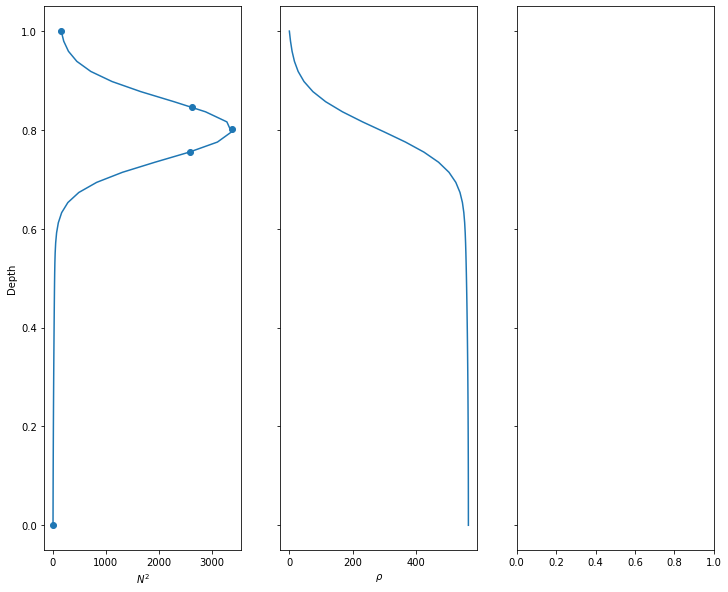

In [5]:
fig, ax = plt.subplots(1,3,figsize=(12,10),sharey=True)

zs = np.linspace(0,1)
rho = np.zeros(len(zs))
for i in range(0,len(zs)):
    rho[i],_ =  integrate.quad(SS,zs[i],1)

ax[0].plot(N2(zs),zs)
ax[1].plot(rho,zs)
ax[0].scatter(N2(z),z)

ax[0].set_ylabel('Depth')
ax[0].set_xlabel(r'$N^2$')
ax[1].set_xlabel(r'$\rho$')

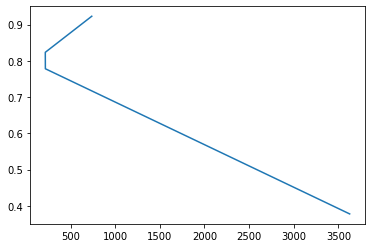

In [6]:
plt.plot(Htot*h/sum(h),zc)

In [7]:
# To get the mean flow profiles we use the first baroclinic mode and an 'ocean-Charney' profile.
# Both of these require the QG stretching matrix, which we now construct.
DS = np.diag(1/N2(z[1:-1]))
D0 = np.zeros((nz-1,nz))
D0[:,:-1] = 2*np.diag(1/(h[:-1]+h[1:]))
D0[:,1:] = D0[:,1:] - 2*np.diag(1/(h[:-1]+h[1:]))
D = DS@D0
L = (1/h)*(np.vstack((np.zeros((1,nz)),D))-np.vstack((D,np.zeros((1,nz)))))
L = L.T # Use C/Python's indexing convention rather than Fortran/Matlab.

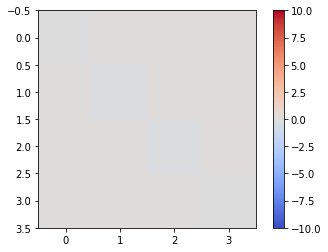

In [8]:
plt.imshow(L,cmap=plt.cm.coolwarm,vmin=-10,vmax=10)
plt.colorbar()

In [9]:
(vals,vecs) = np.linalg.eig(L)
ind = np.argsort(-vals)
first_bc_mode = vecs[:,ind[1]]
first_bc_mode /= first_bc_mode[-1] # sign convention and normalization are that the first baroclinic mode is 1 at the top

[3.47070231e-01 6.72369924e-02 7.33611738e-18 4.30399805e-03]


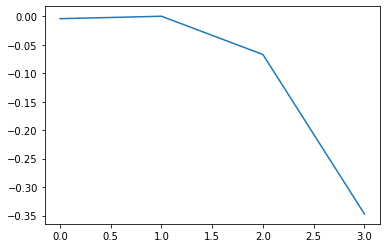

In [10]:
print(-vals)
plt.plot(vals[::-1])

In [11]:
# Next we need the ocean-Charney profile. It is defined so that the mean PV gradient is a constant, and u=u'=0 at the bottom.
L_oc = L[:-1,1:]
oc_profile = np.linalg.solve(L_oc,np.ones(nz-1))
oc_profile = np.concatenate((np.zeros(1),oc_profile))
oc_profile /= oc_profile[-1] # sign convention and normalization are that the ocean-Charney profile is 1 at the top

In [12]:
# Now set the mean velocity as a linear combination of the first baroclinic mode and the ocean-Charney profile:
u_bar = 0.25*first_bc_mode - 0.05*oc_profile

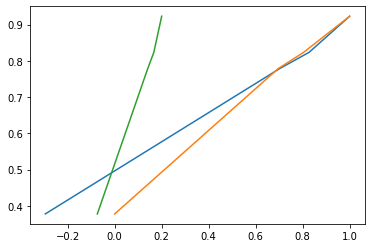

In [13]:
# As a gut check, plot the profiles.
plt.plot(vecs[:,ind[1]],zc,oc_profile,zc,u_bar,zc)
#plt.plot((L - vals[ind[1]]*np.eye(nz))@vecs[:,ind[1]],z[:-1])

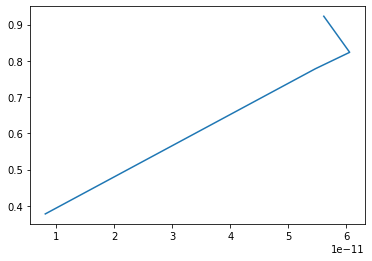

In [14]:
# Also plot the mean PV gradient. It needs to change sign at least once in order for the system to be baroclinically unstable.
# You also need to include planetary beta when assessing whether the mean PV gradient changes sign.
# Note that the ocean-Charney profile appears to have a non-constant PV gradient. What is happening is that
# the 2nd order discretization can't distinguish between a PV gradient and a surface buoyancy gradient in the top layer.
# The ocean-Charney profile has a constant PV gradient and a nonzero surface buoyancy gradient.
qy_bar = -(1/Htot**2)*L@u_bar # The factor of 1/4000**2 scales for a total depth of 4 km, which is needed only to compare to planetary beta.
plt.plot(qy_bar + 2.E-11,zc)

In [15]:
# Now write 
#  (i)   the stratification function S = f^2/N^2(z) evaluated at interface heights
#  (ii)  the layer thicknesses, and
#  (iii) the mean flow profile
# Recall that the indexing convention in the QGN model is left-handed, like most ocean models, 
# i.e. the lowest index is at the top of the ocean and the last index is at the bottom of the ocean.
S = np.zeros(nz+1)
for i in range(nz+1):
    S[nz-i] = 1/N2(z[i])

In [29]:
#/* Initialize vertical modes */
H = Htot*(h/sum(h))

L = np.zeros((nz,nz))
#    /* Set elements of L ([Del+L]psi=q) */
L[0,1] = 2*S[0]/(H[0]*(H[0]+H[1]))
L[0,0] =-L[0,1]
if (nz > 2):
    for k in range(1,(nz-1)): 
        L[k,k-1] = 2*S[k-1]/(H[k]*(H[k]+H[k-1]))
        L[k,k+1] = 2*S[k]/(H[k]*(H[k]+H[k+1]))
        L[k,k]   =-(L[k,k-1]+L[k,k+1])
        
      
L[nz-1,nz-2] = 2*S[nz-2]/(H[nz-1]*(H[nz-1]+H[nz-2]))
L[nz-1,nz-1]   = -L[nz-1,nz-2]


# Initialize PV gradient
qyBar = np.dot(L, -u_bar)


# Calculate modes
import scipy
Modes = scipy.linalg.lapack.dgeev(L)[3]
EVals = scipy.linalg.lapack.dgeev(L)[0]

## Normalize
for k in range(0,nz):
    tmp = np.sum(h*Modes[:,k]**2)
    Modes[:,k] = Modes[:,k] / np.sqrt(tmp)
    
Modes_sorted = Modes[:,np.argsort(-EVals)]
EVals_sorted = EVals[np.argsort(-EVals)]

In [34]:
S.tofile("S.dat")

np.flip(h).tofile("H.dat")

np.flip(zc).tofile("zc.dat")

np.flip(u_bar).tofile("UBar.dat")

np.flip(qyBar).tofile("qyBar.dat")

Modes_sorted.tofile("Modes.dat")

EVals_sorted.tofile("EVals.dat")

In [35]:
import netCDF4
# Write to NetCDF files for Chapel

f = netCDF4.Dataset('background_rachel_4.nc', 'w', format='NETCDF4')
 
tmp_z_layer = f.createDimension('z_interface', nz+1)
tmp_z_interface = f.createDimension('z_layer', nz)

tmp_zi = f.createVariable('zi', 'f8', ('z_interface'))
setattr(tmp_zi, 'long_name', "Interface depths")
setattr(tmp_zi, 'units', "m")
       
tmp_zl = f.createVariable('zl', 'f8', ('z_layer'))
setattr(tmp_zl, 'long_name', "Layer depths")
setattr(tmp_zl, 'units', "m")

tmp_H = f.createVariable('H', 'f8', ('z_layer'))
setattr(tmp_H, 'long_name', "Layer thicknesses")
setattr(tmp_H, 'units', "m")

tmp_S = f.createVariable('S', 'f8', ('z_interface'))
setattr(tmp_S, 'long_name', "Stratification function, f^2/N^2(z)")
setattr(tmp_S, 'units', "nondim")

tmp_uBar = f.createVariable('uBar', 'f8', ('z_layer'))
setattr(tmp_uBar, 'long_name', "Background shear")
setattr(tmp_uBar, 'units', "m s-1")

tmp_qyBar = f.createVariable('qyBar', 'f8', ('z_layer'))
setattr(tmp_qyBar, 'long_name', "Background PV gradient")
setattr(tmp_qyBar, 'units', "s-1")

tmp_EVals = f.createVariable('EVals', 'f8', ('z_layer'))
setattr(tmp_EVals, 'long_name', "Baroclinic eigenvalues")
setattr(tmp_EVals, 'units', "m-1")

tmp_Modes = f.createVariable('Modes', 'f8', ('z_layer','z_layer'))
setattr(tmp_Modes, 'long_name', "Baroclinic eigenmodes")
setattr(tmp_Modes, 'units', "nondim")

f['zi'][:] = z
f['zl'][:] = np.flip(zc)
f['H'][:] = np.flip(h)
f['S'][:] = S
f['uBar'][:] = np.flip(u_bar)
f['qyBar'][:] = np.flip(qyBar)
f['Modes'][:,:] = Modes_sorted
f['EVals'][:] = EVals_sorted

f.close()